### Random Forest - Ensemble Model for Churn Prediction

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

X_train = pd.read_csv('data/processed/X_train_scaled.csv')
X_test = pd.read_csv('data/processed/X_test_scaled.csv')
y_train = pd.read_csv('data/processed/y_train.csv')['churn']
y_test = pd.read_csv('data/processed/y_test.csv')['churn']

print(f"Training set: {X_train.shape}")
print(f"Test set (holdout): {X_test.shape}")
print(f"\nFeatures ({len(X_train.columns)}):")
print(X_train.columns.tolist())

print("\nClass distribution in training set:")
print(y_train.value_counts())
print("\nPercentage:")
print(y_train.value_counts(normalize=True) * 100)

Training set: (8000, 15)
Test set (holdout): (2000, 15)

Features (15):
['credit_score', 'gender', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'country_Germany', 'country_Spain', 'has_balance', 'age_group', 'balance_per_product', 'tenure_age_ratio']

Class distribution in training set:
churn
0    6370
1    1630
Name: count, dtype: int64

Percentage:
churn
0    79.625
1    20.375
Name: proportion, dtype: float64


### Model Configuration
Random Forest
 - Handles non-linear relationships
 - Robust to outliers
 - Provides feature importance
 - Less prone to overfitting than single decision tree
 - Works well without extensive hyperparameter tuning

Random Forest Configuration:
- n_estimators: 100 (number of trees)
- max_depth: 10 (prevent overfitting)
- min_samples_split: 10
- min_samples_leaf: 5
- class_weight: balanced (handles 79.6% vs 20.4% imbalance)
- SMOTE: Will be applied inside CV folds


Using 5-Fold Stratified Cross-Validation
Each fold: ~1600 samples
Cross-Validation Results (5 folds)
Accuracy:  0.8197 ± 0.0083
Precision: 0.5471 ± 0.0169
Recall:    0.6712 ± 0.0388
F1-Score:  0.6024 ± 0.0217
ROC-AUC:   0.8543 ± 0.0117

Training time: 2.43 seconds


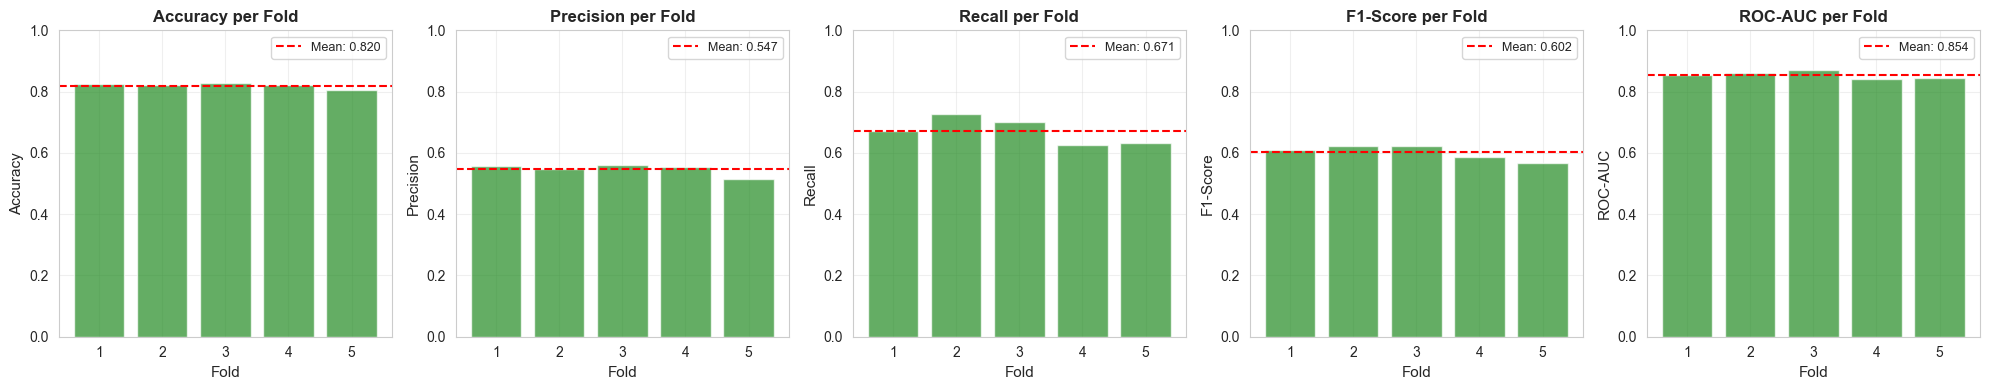

In [2]:
classifier = RandomForestClassifier(
    n_estimators=100,        # Number of trees in the forest
    max_depth=10,            # Maximum depth of each tree (prevents overfitting)
    min_samples_split=10,    # Minimum samples required to split a node
    min_samples_leaf=5,      # Minimum samples required at leaf node
    class_weight='balanced', # Handle class imbalance (3.91:1 ratio)
    random_state=42,         # Reproducibility
    n_jobs=-1                # Use all CPU cores
)

# Create pipeline with SMOTE
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', classifier)
])

# Setup cross-validation
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f"\nUsing {n_folds}-Fold Stratified Cross-Validation")
print(f"Each fold: ~{len(X_train)//n_folds} samples")

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

start_time = time.time()

# Perform cross-validation
cv_scores = cross_validate(
    pipeline, X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

elapsed_time = time.time() - start_time

print("Cross-Validation Results (5 folds)")
print(f"Accuracy:  {cv_scores['test_accuracy'].mean():.4f} ± {cv_scores['test_accuracy'].std():.4f}")
print(f"Precision: {cv_scores['test_precision'].mean():.4f} ± {cv_scores['test_precision'].std():.4f}")
print(f"Recall:    {cv_scores['test_recall'].mean():.4f} ± {cv_scores['test_recall'].std():.4f}")
print(f"F1-Score:  {cv_scores['test_f1'].mean():.4f} ± {cv_scores['test_f1'].std():.4f}")
print(f"ROC-AUC:   {cv_scores['test_roc_auc'].mean():.4f} ± {cv_scores['test_roc_auc'].std():.4f}")
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Visualize CV results across folds
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    scores_per_fold = cv_scores[f'test_{metric}']
    axes[idx].bar(range(1, 6), scores_per_fold, alpha=0.7, color='forestgreen')
    axes[idx].axhline(y=scores_per_fold.mean(), color='red', linestyle='--', 
                     label=f'Mean: {scores_per_fold.mean():.3f}')
    axes[idx].set_xlabel('Fold', fontsize=11)
    axes[idx].set_ylabel(name, fontsize=11)
    axes[idx].set_title(f'{name} per Fold', fontsize=12, fontweight='bold')
    axes[idx].set_ylim([0, 1])
    axes[idx].legend(fontsize=9)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Train on full training set

In [3]:
pipeline.fit(X_train, y_train)

,steps,"[('smote', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10


### Evaluate on Hold-Out test set

In [4]:
# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nTest Set Results (2,000 samples):")
print(f"{'='*60}")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_roc_auc:.4f}")

# Detailed classification report
print(f"\n{'='*60}")
print("Detailed Classification Report")
print(f"{'='*60}")
print(classification_report(y_test, y_pred, 
                          target_names=['Not Churned', 'Churned'],
                          digits=4))


Test Set Results (2,000 samples):
Accuracy:  0.8260
Precision: 0.5577
Recall:    0.7002
F1-Score:  0.6209
ROC-AUC:   0.8617

Detailed Classification Report
              precision    recall  f1-score   support

 Not Churned     0.9181    0.8581    0.8871      1593
     Churned     0.5577    0.7002    0.6209       407

    accuracy                         0.8260      2000
   macro avg     0.7379    0.7792    0.7540      2000
weighted avg     0.8447    0.8260    0.8329      2000



### Confusion Matrix


Confusion Matrix:
                Predicted
              Not  Churned
Actual Not  [ 1367    226]
       Yes  [  122    285]

Breakdown:
  - True Negatives: 1367
  - False Positives: 226
  - False Negatives: 122
  - True Positives: 285


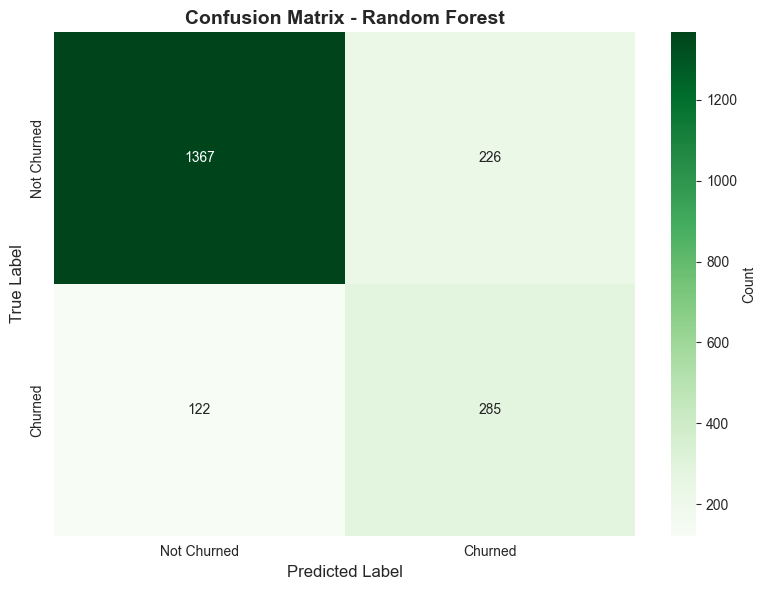

In [5]:
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print("                Predicted")
print("              Not  Churned")
print(f"Actual Not  [{cm[0,0]:5d}  {cm[0,1]:5d}]")
print(f"       Yes  [{cm[1,0]:5d}  {cm[1,1]:5d}]")

print("\nBreakdown:")
print(f"  - True Negatives: {cm[0,0]}")
print(f"  - False Positives: {cm[0,1]}")
print(f"  - False Negatives: {cm[1,0]}")
print(f"  - True Positives: {cm[1,1]}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

### ROC CURVE

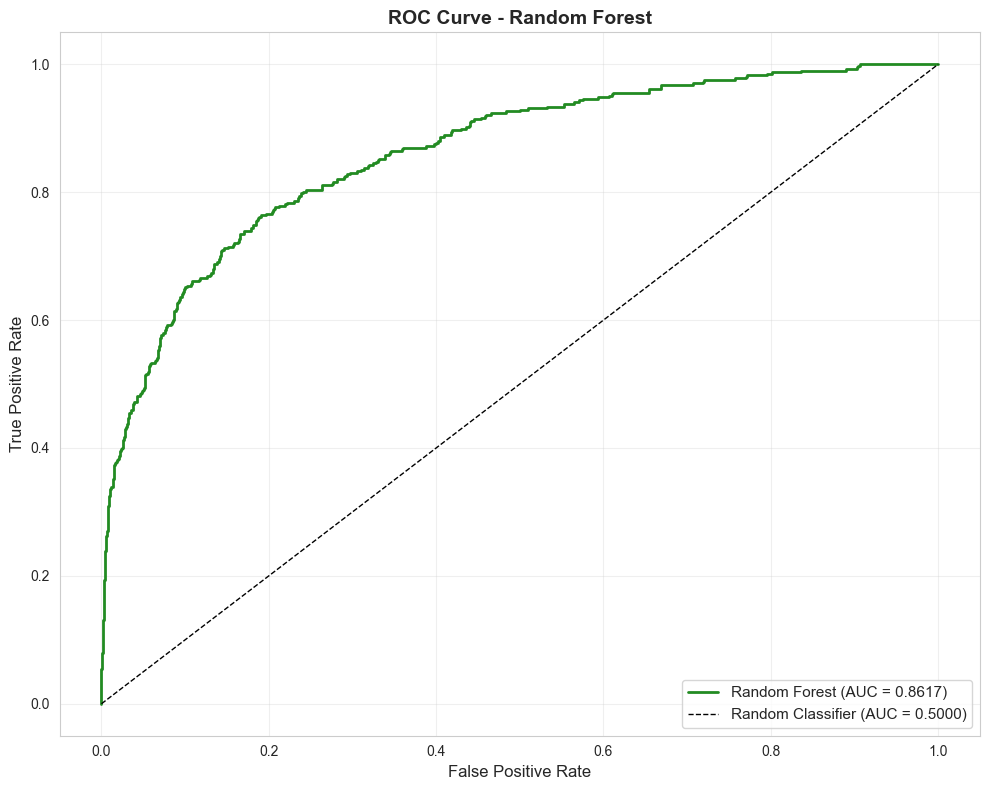


ROC-AUC Score: 0.8617


In [6]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {test_roc_auc:.4f})', 
         linewidth=2, color='forestgreen')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Random Forest', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC-AUC Score: {test_roc_auc:.4f}")

### Precision-Recall Curve

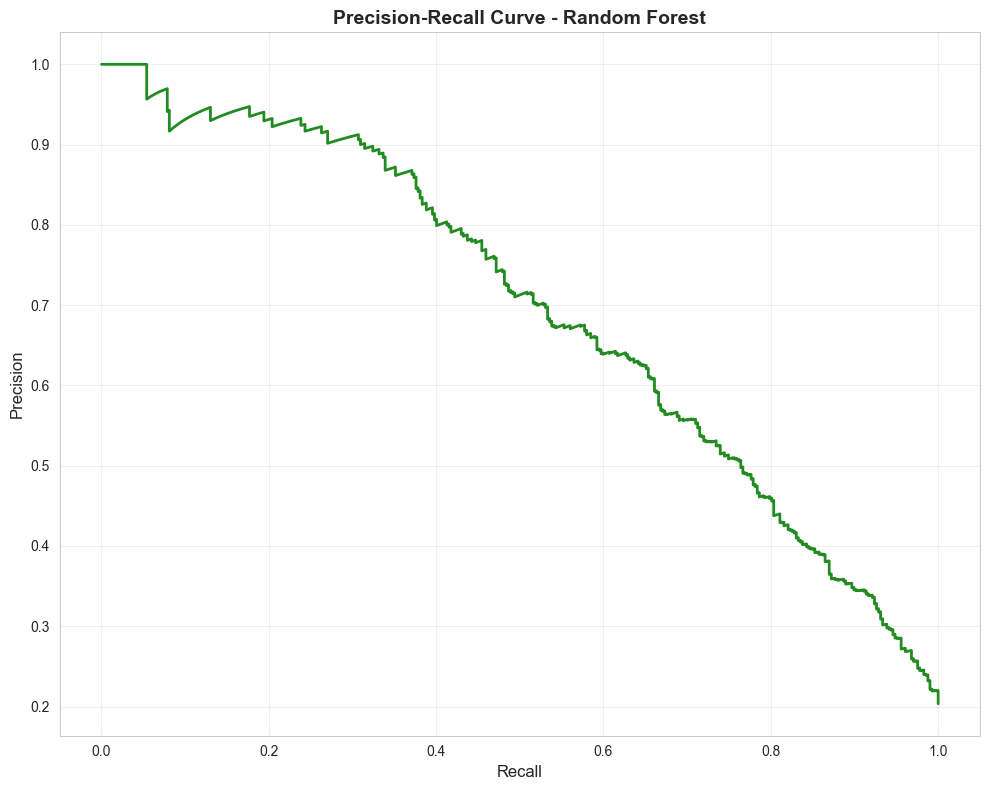

In [7]:
# Calculate precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, linewidth=2, color='forestgreen')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Random Forest', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Feature Importance


Top 10 Most Important Features:
            Feature  Importance
                age    0.264139
    products_number    0.214620
          age_group    0.082187
      active_member    0.070665
balance_per_product    0.059590
            balance    0.053103
    country_Germany    0.051319
   tenure_age_ratio    0.047899
             tenure    0.038635
   estimated_salary    0.031254

Interpretation:
  - Based on Gini impurity reduction
  - Higher value = more important for splits
  - Sum of all importances = 1.0


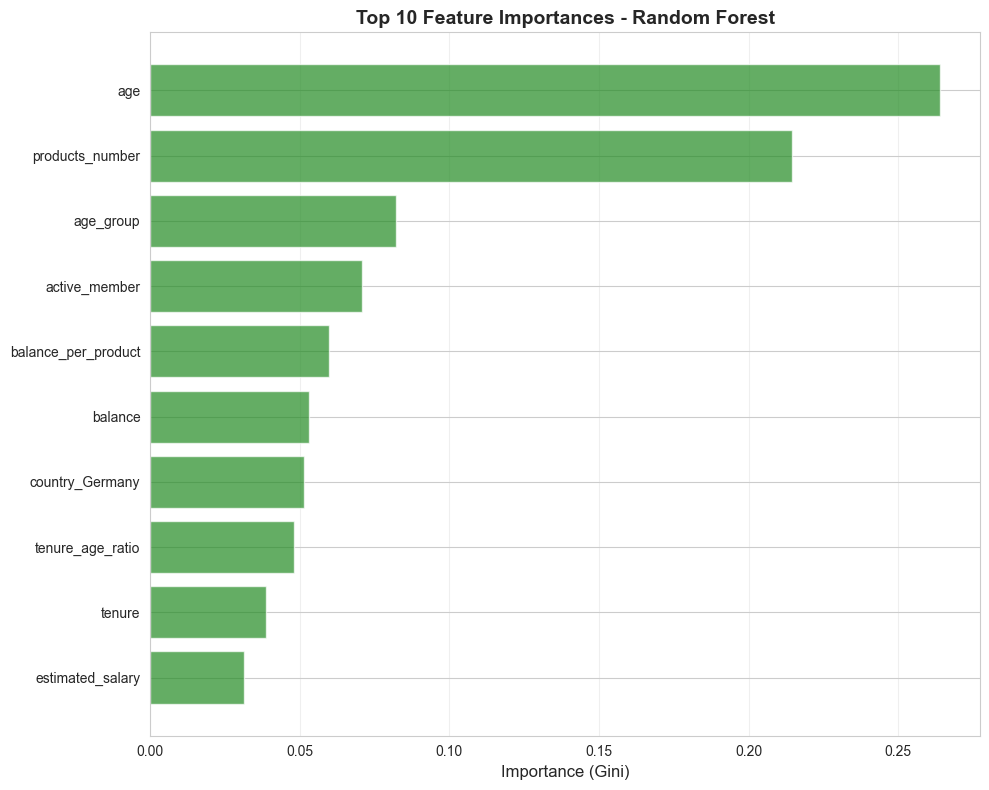


All Feature Importances:
            Feature  Importance
                age    0.264139
    products_number    0.214620
          age_group    0.082187
      active_member    0.070665
balance_per_product    0.059590
            balance    0.053103
    country_Germany    0.051319
   tenure_age_ratio    0.047899
             tenure    0.038635
   estimated_salary    0.031254
             gender    0.028872
       credit_score    0.027976
        has_balance    0.013906
      country_Spain    0.009347
        credit_card    0.006487


In [8]:
# Get trained Random Forest model from pipeline
rf_model = pipeline.named_steps['classifier']

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

print("\nInterpretation:")
print("  - Based on Gini impurity reduction")
print("  - Higher value = more important for splits")
print("  - Sum of all importances = 1.0")

# Visualize top 10 features
plt.figure(figsize=(10, 8))
top_10 = feature_importance.head(10)
plt.barh(range(len(top_10)), top_10['Importance'], color='forestgreen', alpha=0.7)
plt.yticks(range(len(top_10)), top_10['Feature'])
plt.xlabel('Importance (Gini)', fontsize=12)
plt.title('Top 10 Feature Importances - Random Forest', 
         fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# All features importance
print("\nAll Feature Importances:")
print(feature_importance.to_string(index=False))


### Save Results

In [10]:
results_rf = pd.DataFrame({
    'y_test': y_test.values,
    'y_pred': y_pred,
    'y_proba': y_pred_proba
})

results_rf.to_csv(
    'data/processed/random_forest_results.csv',
    index=False
)

### Model Summary

In [9]:
print(f"""
Model: Random Forest (Ensemble of 100 Decision Trees)

Cross-Validation Performance (5-fold):
  • Mean Accuracy:  {cv_scores['test_accuracy'].mean():.4f} Std: {cv_scores['test_accuracy'].std():.4f}
  • Mean Precision: {cv_scores['test_precision'].mean():.4f} Std: {cv_scores['test_precision'].std():.4f}
  • Mean Recall:    {cv_scores['test_recall'].mean():.4f} Std: {cv_scores['test_recall'].std():.4f}
  • Mean F1-Score:  {cv_scores['test_f1'].mean():.4f} Std: {cv_scores['test_f1'].std():.4f}
  • Mean ROC-AUC:   {cv_scores['test_roc_auc'].mean():.4f} Std: {cv_scores['test_roc_auc'].std():.4f}
Test Set Performance (holdout):
  • Accuracy:  {test_accuracy:.4f}
  • Precision: {test_precision:.4f}
  • Recall:    {test_recall:.4f}
  • F1-Score:  {test_f1:.4f}
  • ROC-AUC:   {test_roc_auc:.4f}

Training Time: {elapsed_time:.2f} seconds
""")


Model: Random Forest (Ensemble of 100 Decision Trees)

Cross-Validation Performance (5-fold):
  • Mean Accuracy:  0.8197 Std: 0.0083
  • Mean Precision: 0.5471 Std: 0.0169
  • Mean Recall:    0.6712 Std: 0.0388
  • Mean F1-Score:  0.6024 Std: 0.0217
  • Mean ROC-AUC:   0.8543 Std: 0.0117
Test Set Performance (holdout):
  • Accuracy:  0.8260
  • Precision: 0.5577
  • Recall:    0.7002
  • F1-Score:  0.6209
  • ROC-AUC:   0.8617

Training Time: 2.43 seconds

